# Optimizing fits

At this point, we know how to fit functions to opacity dependence as a function of temperature, pressure, and wavelength. The question remains: Is our fit as good as it can be?

Some of the tweaking, of course, occurs during the fitting process. For instance, a neural network's weights are optimized during a training process. But the *hyperparameters* of these fits — such as how many polynomial terms to include in the fit — are currently fixed for each fit.

In this tutorial, we'll demonstrate how `cortecs` can optimize its hyperparameters. This "optimization" process refers to how well the original data can be reconstructed given a maximum size of the compression model. This process essentially performs a grid search to find the hyperparameters with the lowest mean-squared error.

Let's get started! We'll quickly run through a standard neural network fit to get things going. Please reference the neural network-fitting notebook for more detailed information on how to do so.

## Setting up the fit

In [1]:
import numpy as np
import random
import os

import cortecs
from cortecs.opac.opac import *
from cortecs.fit.fit import *
from cortecs.eval.eval import *
from cortecs.opt.opt import *

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)

In [2]:
T_filename = "temperatures.npy"
P_filename = "pressures.npy"
wl_filename = "wavelengths.npy"

cross_sec_filename = "absorb_coeffs_C2H4.npy"

load_kwargs = {
    "T_filename": T_filename,
    "P_filename": P_filename,
    "wl_filename": wl_filename,
}
opac_obj = Opac(cross_sec_filename, loader="platon", load_kwargs=load_kwargs)

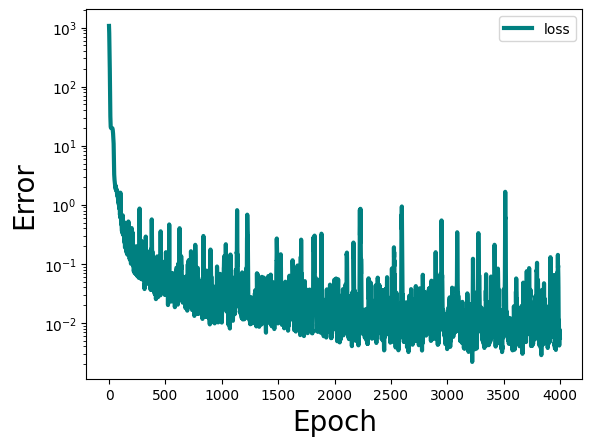

In [3]:
fitter = Fitter(opac_obj, method="neural_net")
res = cortecs.fit.fit_neural_net.fit_neural_net(
    fitter.opac.cross_section[:, :, -2],
    fitter.opac.T,
    fitter.opac.P,
    None,
    n_layers=3,
    n_neurons=8,
    activation="sigmoid",
    learn_rate=0.04,
    loss="mean_squared_error",
    epochs=4000,
    verbose=0,
    sequential_model=None,
    plot=True,
)

Things look pretty good — let's check to be sure.

13/13 [==============================] - 0s 390us/step


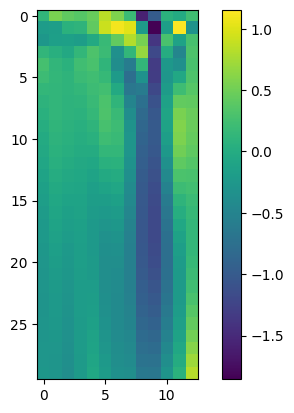

In [4]:
history, neural_network = res
P_unraveled = unravel_data(fitter.opac.P, fitter.opac.T, None, tileboth=True)
T_unraveled = unravel_data(fitter.opac.T, fitter.opac.P, None, tileboth=False)
input_array = np.column_stack([T_unraveled, P_unraveled])

npres = len(fitter.opac.P)
ntemp = len(fitter.opac.T)

predictions = neural_network.predict(input_array)
plt.imshow(
    100
    * (predictions.reshape(ntemp, npres) - fitter.opac.cross_section[:, :, -1])
    / predictions.reshape(ntemp, npres)
)
plt.colorbar()

## Optimization

In [5]:
optimizer = Optimizer(fitter)

Next, we need to restrict how many hyperparameters the `Optimizer` tests. 

We'll first define the `max_size` parameter. This sets how large the opacity fit *at a single point* is. Something on the order of a few KB is probably reasonable, but the decision is up to you — at the end of the day, you want your fit to consume less memory than the opacity function it's fitting! 

In [6]:
max_size = 1.6  # in KB

In addition to this parameter, we need to set the `max_evaluations` parameter. This parameter sets how many models the `Optimizer` tests, essentially setting how long the optimization takes. For the purposes of this tutorial, we'll set a relatively low number. Note that this is an upper bound — setting `max_evaluations = 8`, for instance, will only run 2 model evaluations.

In [7]:
max_evaluations = 16

Now, it's time to run the optimizer!

In [8]:
%%time
optimizer.optimize(max_size, max_evaluations)

max number of weights:  546
max number of layers:  3
max number of neurons / layer:  13


Optimizing neural network hyperparameters: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:09<00:00, 11.83s/it]

CPU times: user 3min 36s, sys: 48.2 s, total: 4min 24s
Wall time: 3min 9s


This took a couple of minutes on a laptop. Let's look at those best-fit parameters.

In [9]:
optimizer.best_params

{'n_layers': 2, 'n_neurons': 13.0, 'activation': 'sigmoid', 'learn_rate': 0.01}

Note that if you'd like, you can set custom ranges for each of the neural net parameters.